<h1><center>SMS Spam Collection : DL Modeling</center></h1>
<hr>

In [1]:
import re
import os
import scipy
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

from tensorflow.keras.layers import Dense, concatenate, Activation, BatchNormalization
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D

from tensorflow.keras.layers import Input, Flatten, Embedding, LSTM
from tensorflow.keras import Model

from keras import regularizers
from keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import optimizers

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./sms_spam_collection_filtered.csv', encoding = "ISO-8859-1")
data.head()

,filtered_text,Label,text_length,presence_of_digit
0,go until jurong point crazy available only in ...,0,20,0
1,ok lar joking wif u oni,0,6,0
2,free entry in 2 a wkly comp to win fa cup fina...,1,30,4
3,u dun say so early hor u c already then say,0,11,0
4,nah i do not think he goes to usf he lives aro...,0,14,0


In [3]:
print("Presence of NULL records : ")
data.isna().sum()

data = data.fillna(' ', axis=1)

print("Presence of NULL records : ")
data.isna().sum()

Presence of NULL records : 
Presence of NULL records : 


filtered_text        0
Label                0
text_length          0
presence_of_digit    0
dtype: int64

# [1] Data Splitting

In [4]:
x_tr, x_te, y_tr, y_te = train_test_split(data.drop('Label', axis=1), data['Label'], stratify=data['Label'], \
                                         test_size=0.10, random_state=47)

x_tr, x_cv, y_tr, y_cv = train_test_split(x_tr, y_tr, stratify=y_tr, test_size=0.20, random_state=47)

print("Train Data : ", x_tr.shape)
print("CV    Data : ", x_cv.shape)
print("Test  Data : ", x_te.shape)

Train Data :  (4011, 3)
CV    Data :  (1003, 3)
Test  Data :  (558, 3)


In [5]:
#https://heartbeat.fritz.ai/how-to-create-a-custom-loss-function-in-keras-637bd312e9ab
def custom_auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

# [2] Data Preparation

## [2.1] Word Vectorizer

In [6]:
w2v_dim = 100

### [2.1.1] Avg. Word2Vector

In [7]:
text_corpus = list()
for sent in tqdm(x_tr['filtered_text'].values):
    text_corpus.append(sent.split())

#text word2vec
text_w2v = Word2Vec(text_corpus, min_count=5, size=w2v_dim, workers=4)

100%|██████████████████████████████████████████████████████████████████████████| 4011/4011 [00:00<00:00, 107796.40it/s]


In [8]:
def text_to_w2v(X):
    word2vec = list()
    for sent in (X['filtered_text'].values):
        temp = np.zeros(w2v_dim)
        word_count = 0
        for word in sent.split():
            try:
                vect = text_w2v.wv[word]
            except KeyError:
                vect = np.zeros(w2v_dim)
            except Exception as e:
                print(e)
            temp += vect
            word_count += 1
        if word_count != 0:
            temp /= word_count
        else:
            temp = np.zeros(w2v_dim)
        word2vec.append(temp)
    return word2vec

In [9]:
#word2vec for sms text
w2v_tr = text_to_w2v(x_tr)
w2v_cv = text_to_w2v(x_cv)
w2v_te = text_to_w2v(x_te)

print("Text Vector for >>>\n* Train data is {0}\n* CV    data is {1}\n* Test  data is {2}."\
      .format(len(w2v_tr), len(w2v_cv), len(w2v_te)))

Text Vector for >>>
* Train data is 4011
* CV    data is 1003
* Test  data is 558.


### [2.1.2] TF-IDF Word2Vector

In [10]:
#train text corpus
text_corpus = list()
for sent in tqdm(x_tr['filtered_text'].values):
    text_corpus.append(sent.split())

#text word2vec
text_tfidfw2v = Word2Vec(text_corpus, min_count=5, size=w2v_dim, workers=4)


#processed review text
tfidfw2v           = TfidfVectorizer(min_df=5)
tfidfw2v_text      = tfidfw2v.fit_transform(x_tr['filtered_text'].values)
tfidfw2v_text_dict = dict(list(zip(tfidfw2v.get_feature_names(), tfidfw2v.idf_)))

100%|██████████████████████████████████████████████████████████████████████████████████████| 4011/4011 [00:00<?, ?it/s]


In [11]:
def text_to_tfidfw2v(X):
    tfidf_vector = list()
    for sent in X['filtered_text'].values:
        temp      = np.zeros(w2v_dim)
        tfidf_val = 0
        for word in sent.split():
            try:
                w_tfidf = tfidfw2v_text_dict[word]
            except KeyError:
                w_tfidf = 0
            try:
                vect = text_tfidfw2v.wv[word]
            except KeyError:
                vect = np.zeros(w2v_dim)
            temp      += ( w_tfidf * vect )
            tfidf_val += w_tfidf
        if tfidf_val != 0:
            temp /= tfidf_val
        else:
            temp = np.zeros(w2v_dim)
        tfidf_vector.append(temp)
    return tfidf_vector

In [12]:
#word2vec for sms text
tfidfw2v_tr = text_to_tfidfw2v(x_tr)
tfidfw2v_cv = text_to_tfidfw2v(x_cv)
tfidfw2v_te = text_to_tfidfw2v(x_te)

print("Text Vector for >>>\n* Train data is {0}\n* CV    data is {1}\n* Test  data is {2}."\
      .format(len(tfidfw2v_tr), len(tfidfw2v_cv), len(tfidfw2v_te)))

Text Vector for >>>
* Train data is 4011
* CV    data is 1003
* Test  data is 558.


## [2.2] Encoding Numerical Features

In [13]:
std = StandardScaler()

#for text_length feature
std.fit(x_tr['text_length'].values.reshape(-1, 1))
print("\nFor SMS Text Length :: Mean={0}, Var={1}.".format(round(std.mean_[0], 5), \
                                                                       round(std.var_[0], 5)))
x_tr_text_length = std.transform(x_tr['text_length'].values.reshape(-1, 1))
x_cv_text_length = std.transform(x_cv['text_length'].values.reshape(-1, 1))
x_te_text_length = std.transform(x_te['text_length'].values.reshape(-1, 1))

#for presence_of_digit feature
std.fit(x_tr['presence_of_digit'].values.reshape(-1, 1))
print("\nFor Presence of Digit in SMS Text :: Mean={0}, Var={1}.".format(round(std.mean_[0], 5), \
                                                                         round(std.var_[0], 5)))
x_tr_digit_present = std.transform(x_tr['presence_of_digit'].values.reshape(-1, 1))
x_cv_digit_present = std.transform(x_cv['presence_of_digit'].values.reshape(-1, 1))
x_te_digit_present = std.transform(x_te['presence_of_digit'].values.reshape(-1, 1))


For SMS Text Length :: Mean=15.62777, Var=122.31445.

For Presence of Digit in SMS Text :: Mean=0.73074, Var=2.94071.


In [14]:
x_tr_numerical = np.hstack((x_tr_text_length, x_tr_digit_present))
x_cv_numerical = np.hstack((x_cv_text_length, x_cv_digit_present))
x_te_numerical = np.hstack((x_te_text_length, x_te_digit_present))

## [2.3] Word Embedding

In [15]:
#making glove vector of all words present in glove_vector file. we can use this dict of words 
#to map our own words into this
embeded_vect = dict()
with open('./glove_vectors', 'rb') as glove_vect:
    glove_model = pickle.load(glove_vect)
    glove_words = list(set(glove_model.keys()))
    
for w in glove_words:
    embeded_vect[w] = glove_model[w]
print("Total of embedding words are {0}.".format(len(embeded_vect)))

Total of embedding words are 51510.


In [16]:
print("Mean text length in All  SMS is : ", round(data['text_length'].mean(), 5) )
print("Mean text length in Ham  SMS is : ", round(data[data['Label']==0]['text_length'].mean(), 5) )
print("Mean text length in Spam SMS is : ", round(data[data['Label']==1]['text_length'].mean(), 5) )

Mean text length in All  SMS is :  15.72128
Mean text length in Ham  SMS is :  14.37016
Mean text length in Spam SMS is :  24.44846


In [17]:
token = Tokenizer()
token.fit_on_texts(x_tr['filtered_text'].values)

#convert each eord in sentence to a word representation
vocab_size   = len(token.word_index) + 1
x_tr_encoded = token.texts_to_sequences(x_tr['filtered_text'].values)
x_cv_encoded = token.texts_to_sequences(x_cv['filtered_text'].values)
x_te_encoded = token.texts_to_sequences(x_te['filtered_text'].values)
print("Vocab size is " , vocab_size)

#pad each sentence with total of max (max_length) sized words
max_length = 30
x_tr_padded = pad_sequences(x_tr_encoded, maxlen=max_length, padding='post')
x_cv_padded = pad_sequences(x_cv_encoded, maxlen=max_length, padding='post')
x_te_padded = pad_sequences(x_te_encoded, maxlen=max_length, padding='post')

Vocab size is  7141


In [18]:
#initializing the training matrix for Embed layer
x_tr_embeding_matrix = np.zeros((vocab_size, 300))

for word, i in token.word_index.items():
    embeded_word = embeded_vect.get(word)
    if embeded_word is not None:
        x_tr_embeding_matrix[i] = embeded_word
    else:
        x_tr_embeding_matrix[i] = np.zeros(300)
print(x_tr_embeding_matrix.shape)

(7141, 300)


## [2.4] Vector Combining

In [19]:
#combining avg w2v and numerical features
x_tr_w2v = np.hstack((w2v_tr, x_tr_numerical))
x_cv_w2v = np.hstack((w2v_cv, x_cv_numerical))
x_te_w2v = np.hstack((w2v_te, x_te_numerical))

print("Shape of combined vectors are : \nTrain : {0}\nCV    : {1}\nTest  : {2}"\
      .format(x_tr_w2v.shape, x_cv_w2v.shape, x_te_w2v.shape))

Shape of combined vectors are : 
Train : (4011, 102)
CV    : (1003, 102)
Test  : (558, 102)


In [20]:
#combining tfidf w2v and numerical features
x_tr_tfidf = np.hstack((tfidfw2v_tr, x_tr_numerical))
x_cv_tfidf = np.hstack((tfidfw2v_cv, x_cv_numerical))
x_te_tfidf = np.hstack((tfidfw2v_te, x_te_numerical))

print("Shape of combined vectors are : \nTrain : {0}\nCV    : {1}\nTest  : {2}"\
      .format(x_tr_tfidf.shape, x_cv_tfidf.shape, x_te_tfidf.shape))

Shape of combined vectors are : 
Train : (4011, 102)
CV    : (1003, 102)
Test  : (558, 102)


# [3] Modeling

In [21]:
model_performances = dict()
epoch              = 30
batch              = 64

In [22]:
def plot_model_performance(model_data):
    tr_loss = model_data.history['loss']
    tr_auc  = model_data.history['custom_auc']
    cv_loss = model_data.history['val_loss']
    cv_auc  = model_data.history['val_custom_auc']

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(tr_loss, label='Train Loss', color='orange')
    plt.plot(cv_loss, label='CV Loss', color='blue')
    plt.grid()
    plt.legend()
    plt.title('Model Loss')

    plt.subplot(122)
    plt.plot(tr_auc, label='Train AUC', color='orange')
    plt.plot(cv_auc, label='CV AUC', color='blue')
    plt.grid()
    plt.legend()
    plt.title('Model AUC')

    plt.tight_layout()
    plt.show()

In [23]:
def plot_confusion_matrix(actual, predicted):
    """
    for plotting confusion matrix for predicted and actual class labels
    """
    C = confusion_matrix(actual, predicted) #confusion matrix
    A = ((C.T)/(C.sum(axis=1))).T           #recall matrix    (row sum=1)
    B = (C/C.sum(axis=0))                   #precision matrix (col sum=1)
    labels = list(range(2))

    plt.figure(figsize=(15, 5))
    
    ax1=plt.subplot(131)
    #print('-'*10, 'Confusion Matrix', '-'*10)
    #plt.figure(figsize=(5, 4))
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    ax2=plt.subplot(132)
    #print('-'*10, 'Precision Matrix (ColSum=1)', '-'*10)#B
    #plt.figure(figsize=(5, 4))
    sns.heatmap(B, annot=True, cmap='YlGn', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax2)
    ax2.set_title('Precision Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    ax3=plt.subplot(133)
    #print('-'*10, 'Recall Matrix (RowSum=1)', '-'*10)#A
    #plt.figure(figsize=(5, 4))
    sns.heatmap(A, annot=True, cmap='YlOrBr', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=ax3)
    ax3.set_title('Recall Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    plt.tight_layout()
    plt.show()

In [24]:
def model_prediction(clf, data, actual_labels):
    prediction_probs = clf.predict(data)
    prediction       = [ 0 if x < 0 else 1 for x in prediction_probs ]
    plot_confusion_matrix(actual_labels, prediction)
    return prediction

## [3.1] Simple Dense Model

In [25]:
def simple_dense_model(shape, print_summary=False):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(shape,)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3) ,metrics=[custom_auc])
    if print_summary:
        model.summary()
    return model
stop_early_d1 = EarlyStopping(monitor='val_custom_auc', min_delta=1e-5, patience=30, verbose=0, mode='auto', \
                           restore_best_weights=True)

### [3.1.1] with Avg. Word2Vec 

In [26]:
checkpoint_d1 = ModelCheckpoint("./model_checkpoint/dense_model_m1.h5",monitor="val_custom_auc",mode="max",\
                                save_best_only = True,verbose=1)

#training model with given data
simple_dense  = simple_dense_model(x_tr_w2v.shape[1])
model_history = simple_dense.fit(x_tr_w2v, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_w2v, y_cv), \
                                 use_multiprocessing=True, callbacks=[checkpoint_d1, stop_early_d1])

Epoch 1/30
53/63 [========================>.....] - ETA: 0s - loss: 0.4817 - custom_auc: 0.8494
Epoch 00001: val_custom_auc improved from -inf to 0.95211, saving model to ./model_checkpoint\dense_model_m1.h5
63/63 [==============================] - 1s 9ms/step - loss: 0.4775 - custom_auc: 0.8563 - val_loss: 0.2727 - val_custom_auc: 0.9521
Epoch 2/30
52/63 [=======================>......] - ETA: 0s - loss: 0.3796 - custom_auc: 0.9370
Epoch 00002: val_custom_auc did not improve from 0.95211
63/63 [==============================] - 0s 5ms/step - loss: 0.3599 - custom_auc: 0.9374 - val_loss: 0.2256 - val_custom_auc: 0.9513
Epoch 3/30
62/63 [============================>.] - ETA: 0s - loss: 0.4087 - custom_auc: 0.9312
Epoch 00003: val_custom_auc did not improve from 0.95211
63/63 [==============================] - 0s 5ms/step - loss: 0.4098 - custom_auc: 0.9315 - val_loss: 0.3185 - val_custom_auc: 0.9517
Epoch 4/30
54/63 [========================>.....] - ETA: 0s - loss: 0.3410 - custom_auc

Epoch 29/30
54/63 [========================>.....] - ETA: 0s - loss: 0.3909 - custom_auc: 0.9067
Epoch 00029: val_custom_auc did not improve from 0.95897
63/63 [==============================] - 0s 5ms/step - loss: 0.3766 - custom_auc: 0.9111 - val_loss: 0.1815 - val_custom_auc: 0.9551
Epoch 30/30
54/63 [========================>.....] - ETA: 0s - loss: 0.3729 - custom_auc: 0.9306
Epoch 00030: val_custom_auc did not improve from 0.95897
63/63 [==============================] - 0s 5ms/step - loss: 0.3590 - custom_auc: 0.9355 - val_loss: 0.2334 - val_custom_auc: 0.9565


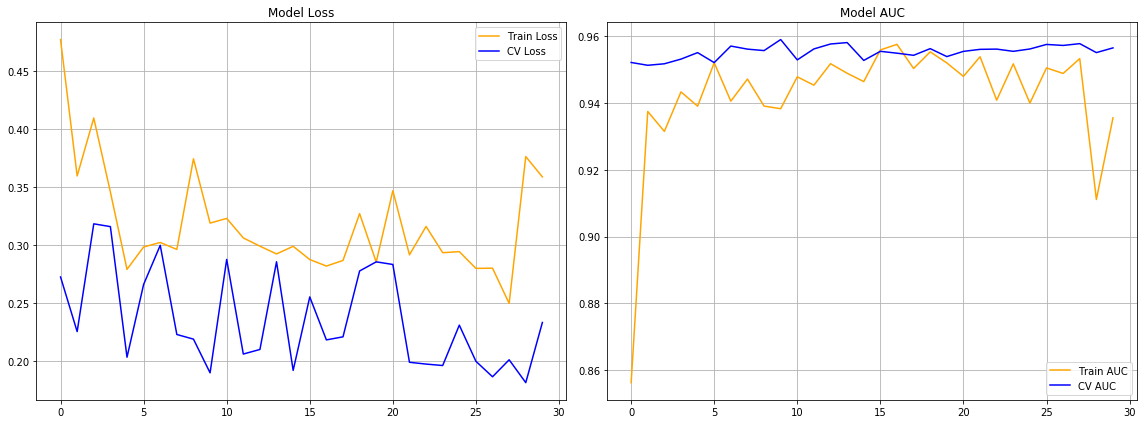

9/9 [==============================] - 0s 4ms/step - loss: 0.1696 - custom_auc: 0.9743


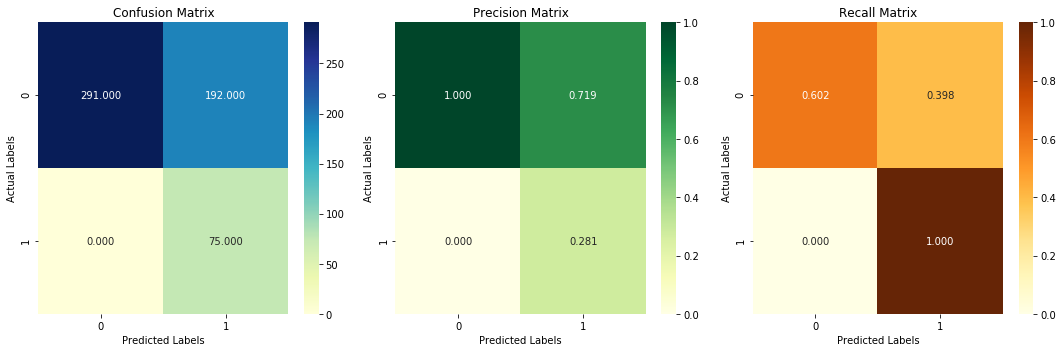

In [27]:
#plotting model performance
plot_model_performance(model_history)

simple_dense = simple_dense_model(x_tr_w2v.shape[1])
simple_dense.load_weights('./model_checkpoint/dense_model_m1.h5')

tr_loss, tr_auc = simple_dense.evaluate(x_tr_w2v, y_tr, batch_size=64)
cv_loss, cv_auc = simple_dense.evaluate(x_cv_w2v, y_cv, batch_size=64)
te_loss, te_auc = simple_dense.evaluate(x_te_w2v, y_te, batch_size=64)

#model prediction on Test data
model_prediction(simple_dense, x_te_w2v, y_te)

model_performances['Simple Dense (avg w2v)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

### [3.1.2] with TF-IDF Word2Vec features

In [28]:
checkpoint_d1 = ModelCheckpoint("./model_checkpoint/dense_model_m2.h5",monitor="val_custom_auc",mode="max",\
                                save_best_only = True,verbose=1)

#training model with given data
simple_dense  = simple_dense_model(x_tr_tfidf.shape[1])
model_history = simple_dense.fit(x_tr_tfidf, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_tfidf, y_cv), \
                                 use_multiprocessing=True, callbacks=[checkpoint_d1, stop_early_d1])

Epoch 1/30
51/63 [=======================>......] - ETA: 0s - loss: 0.5715 - custom_auc: 0.8479
Epoch 00001: val_custom_auc improved from -inf to 0.95282, saving model to ./model_checkpoint\dense_model_m2.h5
63/63 [==============================] - 0s 8ms/step - loss: 0.5350 - custom_auc: 0.8648 - val_loss: 0.2880 - val_custom_auc: 0.9528
Epoch 2/30
53/63 [========================>.....] - ETA: 0s - loss: 0.3448 - custom_auc: 0.9346
Epoch 00002: val_custom_auc improved from 0.95282 to 0.95600, saving model to ./model_checkpoint\dense_model_m2.h5
63/63 [==============================] - 0s 7ms/step - loss: 0.3684 - custom_auc: 0.9315 - val_loss: 0.2197 - val_custom_auc: 0.9560
Epoch 3/30
53/63 [========================>.....] - ETA: 0s - loss: 0.3162 - custom_auc: 0.9489
Epoch 00003: val_custom_auc improved from 0.95600 to 0.95691, saving model to ./model_checkpoint\dense_model_m2.h5
63/63 [==============================] - 0s 6ms/step - loss: 0.3021 - custom_auc: 0.9513 - val_loss: 0.2

Epoch 29/30
54/63 [========================>.....] - ETA: 0s - loss: 0.3520 - custom_auc: 0.9495
Epoch 00029: val_custom_auc did not improve from 0.96068
63/63 [==============================] - 0s 5ms/step - loss: 0.3472 - custom_auc: 0.9519 - val_loss: 0.3172 - val_custom_auc: 0.9574
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.3211 - custom_auc: 0.9486
Epoch 00030: val_custom_auc did not improve from 0.96068
63/63 [==============================] - 0s 8ms/step - loss: 0.3211 - custom_auc: 0.9486 - val_loss: 0.2402 - val_custom_auc: 0.9514


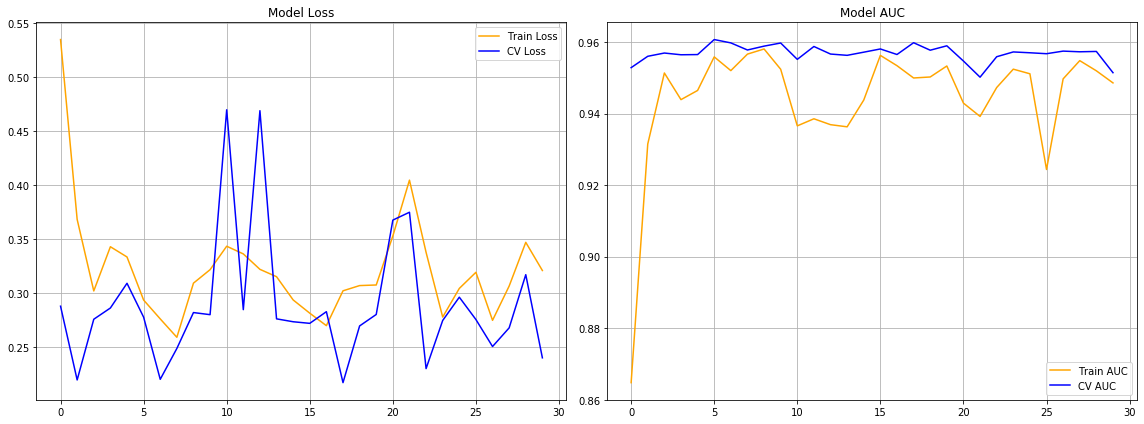

9/9 [==============================] - 0s 4ms/step - loss: 0.1873 - custom_auc: 0.9746


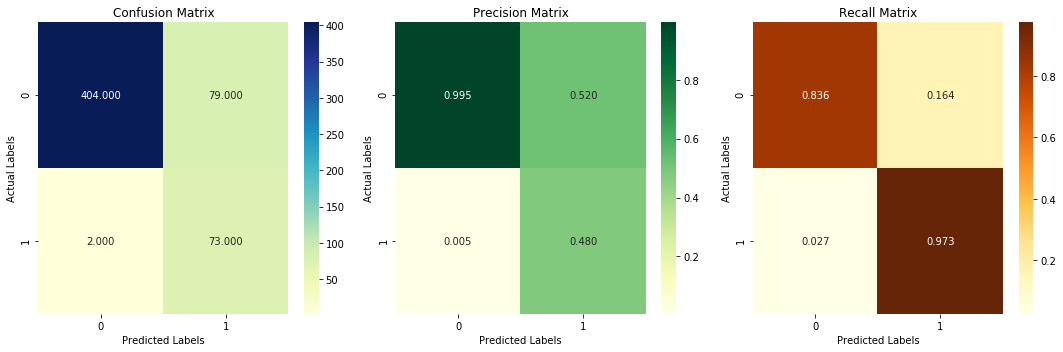

In [29]:
#plotting model performance
plot_model_performance(model_history)

simple_dense = simple_dense_model(x_tr_tfidf.shape[1])
simple_dense.load_weights('./model_checkpoint/dense_model_m2.h5')

tr_loss, tr_auc = simple_dense.evaluate(x_tr_tfidf, y_tr, batch_size=64)
cv_loss, cv_auc = simple_dense.evaluate(x_cv_tfidf, y_cv, batch_size=64)
te_loss, te_auc = simple_dense.evaluate(x_te_tfidf, y_te, batch_size=64)

#model prediction on Test data
model_prediction(simple_dense, x_te_tfidf, y_te)

model_performances['Simple Dense (tfidf w2v)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

## [3.2] Dense Model : Hyper-parameter Tuning

In [30]:
def simple_dense_model1(d1, d2, d3, drp, opt, shape, print_summary=False):
    model = Sequential()
    model.add(Dense(d1, activation='relu', input_shape=(shape,)))
    model.add(Dropout(drp))
    model.add(Dense(d2, activation='relu'))
    model.add(Dropout(drp))
    model.add(Dense(d3, activation='relu'))
    model.add(Dropout(drp))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer=opt ,metrics=[custom_auc])
    if print_summary:
        model.summary()
    return model
stop_early = EarlyStopping(monitor='val_custom_auc', min_delta=1e-5, patience=30, verbose=0, mode='auto', \
                           restore_best_weights=True)

In [31]:
my_auc = make_scorer(roc_auc_score)

hidden_d1 = [ 8, 16, 32, 64, 128 ]
hidden_d2 = [ 8, 16, 32, 64, 128 ]
hidden_d3 = [ 8, 16, 32, 64, 128 ]

m_dropout = [ 0.3, 0.4, 0.5, 0.6, 0.7 ]

#adam1  = optimizers.Adam(lr=1e-3)
#adam2  = optimizers.Adam(lr=1e-4)
#rmsprp = optimizers.RMSprop(lr=1e-3)
m_optimzr = [ 'adam', 'rmsprop' ]

### [3.2.1] with Avg. Word2Vec

In [32]:
param_dict = dict(d1=hidden_d1, d2=hidden_d2, d3=hidden_d3, drp=m_dropout, opt=m_optimzr, shape=[x_tr_w2v.shape[1]] )

model  = KerasClassifier(build_fn=simple_dense_model1, batch_size=batch)
random = RandomizedSearchCV(estimator=model, n_jobs=-1, scoring=my_auc, \
                             param_distributions=param_dict, cv=5)
result = random.fit(x_tr_w2v, y_tr)

print("\n\nBest hyper parameter values for the Train data are : \n{0}".\
      format(random.best_params_))
best_d1  = random.best_params_['d1']
best_d2  = random.best_params_['d2']
best_d3  = random.best_params_['d3']
best_drp = random.best_params_['drp']
best_opt = random.best_params_['opt']

63/63 [==============================] - 0s 4ms/step - loss: 1.9416 - custom_auc: 0.4086


Best hyper parameter values for the Train data are : 
{'shape': 102, 'opt': 'rmsprop', 'drp': 0.5, 'd3': 8, 'd2': 16, 'd1': 32}


In [33]:
checkpoint = ModelCheckpoint("./model_checkpoint/simple_dense1_m3.h5",monitor="val_custom_auc",mode="max",\
                             save_best_only = True,verbose=1)

#training model with given data
simple_dense  = simple_dense_model1(best_d1, best_d2, best_d3, best_drp, best_opt, x_tr_w2v.shape[1], print_summary=True)
model_history = simple_dense.fit(x_tr_w2v, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_w2v, y_cv), \
                                 use_multiprocessing=True, callbacks=[checkpoint, stop_early])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 32)                3296      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

Epoch 24/30
57/63 [==========================>...] - ETA: 0s - loss: 0.5247 - custom_auc: 0.9307
Epoch 00024: val_custom_auc did not improve from 0.95842
63/63 [==============================] - 0s 5ms/step - loss: 0.5381 - custom_auc: 0.9306 - val_loss: 0.5539 - val_custom_auc: 0.9557
Epoch 25/30
57/63 [==========================>...] - ETA: 0s - loss: 0.5470 - custom_auc: 0.9177
Epoch 00025: val_custom_auc did not improve from 0.95842
63/63 [==============================] - 0s 5ms/step - loss: 0.5386 - custom_auc: 0.9206 - val_loss: 0.5659 - val_custom_auc: 0.9532
Epoch 26/30
55/63 [=========================>....] - ETA: 0s - loss: 0.5390 - custom_auc: 0.9090
Epoch 00026: val_custom_auc did not improve from 0.95842
63/63 [==============================] - 0s 5ms/step - loss: 0.5302 - custom_auc: 0.9116 - val_loss: 0.5637 - val_custom_auc: 0.9554
Epoch 27/30
57/63 [==========================>...] - ETA: 0s - loss: 0.5775 - custom_auc: 0.9192
Epoch 00027: val_custom_auc did not improv

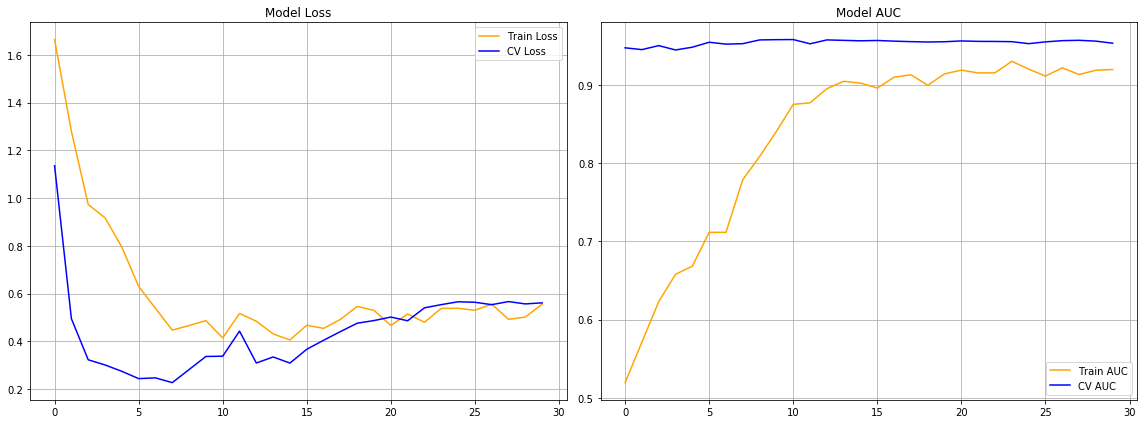

9/9 [==============================] - 0s 3ms/step - loss: 0.2673 - custom_auc: 0.9714


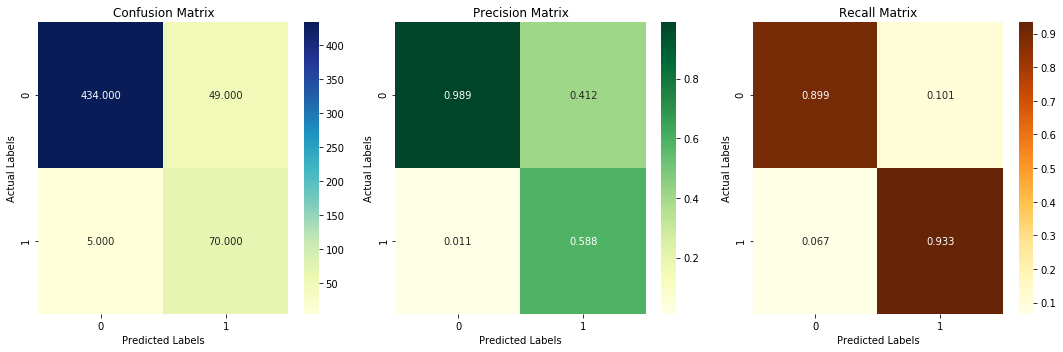

In [34]:
#plotting model performance
plot_model_performance(model_history)

simple_dense = simple_dense_model1(best_d1, best_d2, best_d3, best_drp, best_opt, x_tr_w2v.shape[1])
simple_dense.load_weights('./model_checkpoint/simple_dense1_m3.h5')

tr_loss, tr_auc = simple_dense.evaluate(x_tr_w2v, y_tr, batch_size=64)
cv_loss, cv_auc = simple_dense.evaluate(x_cv_w2v, y_cv, batch_size=64)
te_loss, te_auc = simple_dense.evaluate(x_te_w2v, y_te, batch_size=64)

#model prediction on Test data
model_prediction(simple_dense, x_te_w2v, y_te)

model_performances['Simple Dense Tuned(avg. w2v)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

### [3.2.2] with TF-IDF WOrd2Vec

In [35]:
param_dict = dict(d1=hidden_d1, d2=hidden_d2, d3=hidden_d3, drp=m_dropout, opt=m_optimzr, shape=[x_tr_tfidf.shape[1]] )

model  = KerasClassifier(build_fn=simple_dense_model1, batch_size=batch)
random = RandomizedSearchCV(estimator=model, n_jobs=-1, scoring=my_auc, \
                             param_distributions=param_dict, cv=5)
result = random.fit(x_tr_tfidf, y_tr)

print("\n\nBest hyper parameter values for the Train data are : \n{0}".\
      format(random.best_params_))
best_d1  = random.best_params_['d1']
best_d2  = random.best_params_['d2']
best_d3  = random.best_params_['d3']
best_drp = random.best_params_['drp']
best_opt = random.best_params_['opt']

63/63 [==============================] - 0s 5ms/step - loss: 1.3498 - custom_auc: 0.5838


Best hyper parameter values for the Train data are : 
{'shape': 102, 'opt': 'rmsprop', 'drp': 0.6, 'd3': 16, 'd2': 16, 'd1': 128}


In [36]:
checkpoint = ModelCheckpoint("./model_checkpoint/simple_dense1_m4.h5",monitor="val_custom_auc",mode="max",\
                             save_best_only = True,verbose=1)

#training model with given data
simple_dense  = simple_dense_model1(best_d1, best_d2, best_d3, best_drp, best_opt, x_tr_tfidf.shape[1], print_summary=True)
model_history = simple_dense.fit(x_tr_tfidf, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_tfidf, y_cv), \
                                 use_multiprocessing=True, callbacks=[checkpoint, stop_early])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               13184     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_25 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                

Epoch 24/30
51/63 [=======================>......] - ETA: 0s - loss: 0.5056 - custom_auc: 0.9047
Epoch 00024: val_custom_auc did not improve from 0.96009
63/63 [==============================] - 0s 5ms/step - loss: 0.5111 - custom_auc: 0.9040 - val_loss: 0.5507 - val_custom_auc: 0.9552
Epoch 25/30
62/63 [============================>.] - ETA: 0s - loss: 0.4742 - custom_auc: 0.9163
Epoch 00025: val_custom_auc did not improve from 0.96009
63/63 [==============================] - 0s 5ms/step - loss: 0.4733 - custom_auc: 0.9148 - val_loss: 0.4835 - val_custom_auc: 0.9546
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.4723 - custom_auc: 0.9092
Epoch 00026: val_custom_auc did not improve from 0.96009
63/63 [==============================] - 0s 5ms/step - loss: 0.4723 - custom_auc: 0.9092 - val_loss: 0.5524 - val_custom_auc: 0.9564
Epoch 27/30
57/63 [==========================>...] - ETA: 0s - loss: 0.4984 - custom_auc: 0.9057
Epoch 00027: val_custom_auc did not improv

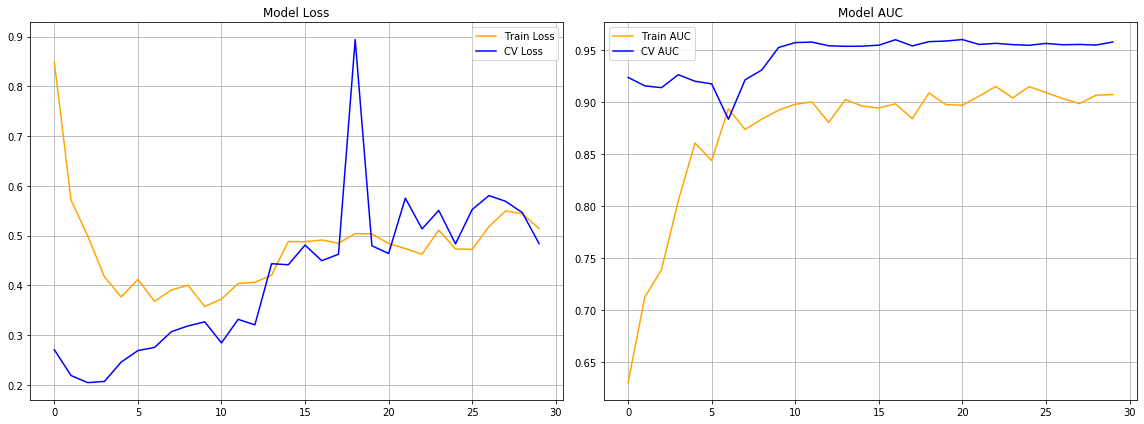

9/9 [==============================] - 0s 5ms/step - loss: 0.5352 - custom_auc: 0.9725


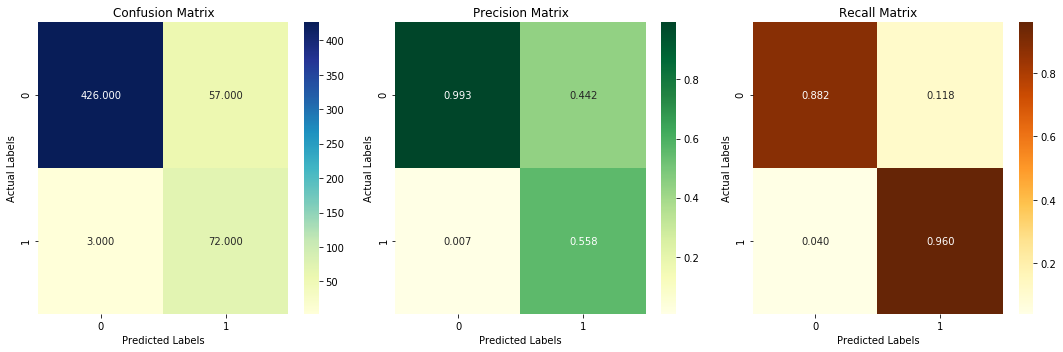

In [37]:
#plotting model performance
plot_model_performance(model_history)

simple_dense = simple_dense_model1(best_d1, best_d2, best_d3, best_drp, best_opt, x_tr_tfidf.shape[1])
simple_dense.load_weights('./model_checkpoint/simple_dense1_m4.h5')

tr_loss, tr_auc = simple_dense.evaluate(x_tr_tfidf, y_tr, batch_size=64)
cv_loss, cv_auc = simple_dense.evaluate(x_cv_tfidf, y_cv, batch_size=64)
te_loss, te_auc = simple_dense.evaluate(x_te_tfidf, y_te, batch_size=64)

#model prediction on Test data
model_prediction(simple_dense, x_te_tfidf, y_te)

model_performances['Simple Dense Tuned(tfidf w2v)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

## [3.3] Simple LSTM 

In [38]:
def lstm_model(shape, print_summary=False):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(shape, 1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-3) ,metrics=[custom_auc])
    if print_summary:
        model.summary()
    return model

stop_early_d1 = EarlyStopping(monitor='val_custom_auc', min_delta=1e-5, patience=30, verbose=0, mode='auto', \
                           restore_best_weights=True)

### [3.3.1] with Avg. Word2Vec

In [42]:
#changing the shape of the array for LSTM
x_tr_w2v_m = np.reshape(x_tr_w2v, (x_tr_w2v.shape[0], x_tr_w2v.shape[1], 1))
x_cv_w2v_m = np.reshape(x_cv_w2v, (x_cv_w2v.shape[0], x_cv_w2v.shape[1], 1))
x_te_w2v_m = np.reshape(x_te_w2v, (x_te_w2v.shape[0], x_te_w2v.shape[1], 1))

In [43]:
checkpoint_d1 = ModelCheckpoint("./model_checkpoint/simple_lstm_m1.h5",monitor="val_custom_auc",mode="max",\
                                save_best_only = True,verbose=1)

#training model with given data
simple_lstm   = lstm_model(x_tr_w2v_m.shape[1])
model_history = simple_lstm.fit(x_tr_w2v_m, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_w2v_m, y_cv), \
                                use_multiprocessing=True, callbacks=[checkpoint_d1, stop_early_d1])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 2.0690 - custom_auc: 0.2424
Epoch 00001: val_custom_auc improved from -inf to 0.12636, saving model to ./model_checkpoint\simple_lstm_m1.h5
63/63 [==============================] - 5s 76ms/step - loss: 2.0690 - custom_auc: 0.2424 - val_loss: 2.0608 - val_custom_auc: 0.1264
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 1.2099 - custom_auc: 0.5726
Epoch 00002: val_custom_auc improved from 0.12636 to 0.94109, saving model to ./model_checkpoint\simple_lstm_m1.h5
63/63 [==============================] - 4s 70ms/step - loss: 1.2099 - custom_auc: 0.5726 - val_loss: 0.2600 - val_custom_auc: 0.9411
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.3152 - custom_auc: 0.9122
Epoch 00003: val_custom_auc improved from 0.94109 to 0.94681, saving model to ./model_checkpoint\simple_lstm_m1.h5
63/63 [==============================] - 4s 70ms/step - loss: 0.3152 - custom_auc: 0.9122 - val_loss: 

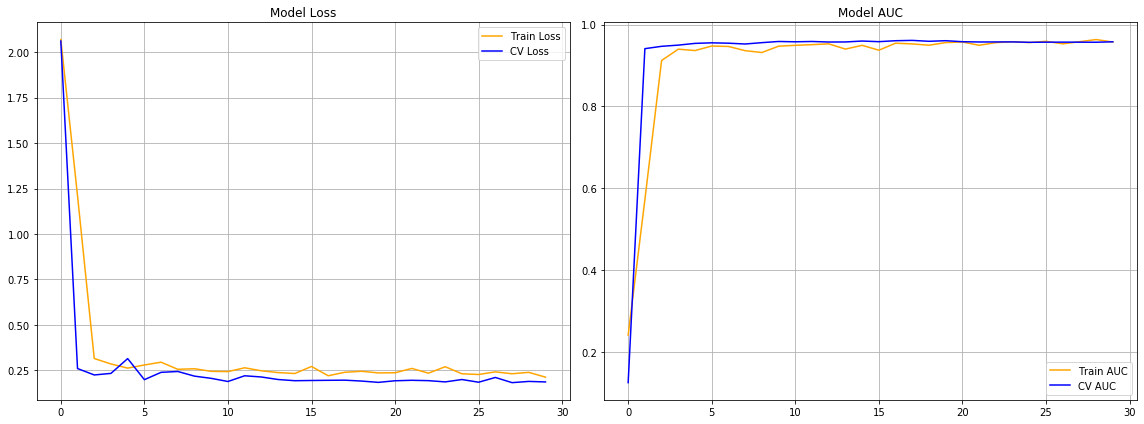

9/9 [==============================] - 0s 26ms/step - loss: 0.1828 - custom_auc: 0.9733


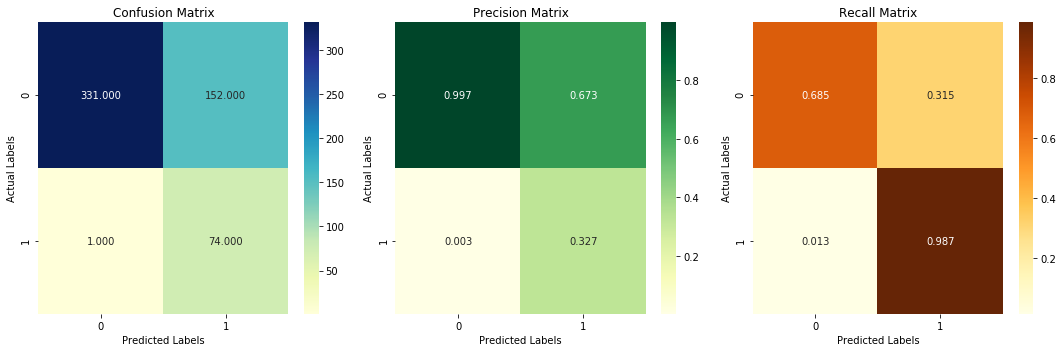

In [44]:
#plotting model performance
plot_model_performance(model_history)

simple_lstm = lstm_model(x_tr_w2v_m.shape[1])
simple_lstm.load_weights('./model_checkpoint/simple_lstm_m1.h5')

tr_loss, tr_auc = simple_lstm.evaluate(x_tr_w2v_m, y_tr, batch_size=batch)
cv_loss, cv_auc = simple_lstm.evaluate(x_cv_w2v_m, y_cv, batch_size=batch)
te_loss, te_auc = simple_lstm.evaluate(x_te_w2v_m, y_te, batch_size=batch)

#model prediction on Test data
model_prediction(simple_lstm, x_te_w2v_m, y_te)

model_performances['Simple LSTM (avg w2v)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

### [3.3.2] with TF-IDF Word2Vec

In [45]:
#changing the shape of the array for LSTM
x_tr_tfidf_m = np.reshape(x_tr_tfidf, (x_tr_tfidf.shape[0], x_tr_tfidf.shape[1], 1))
x_cv_tfidf_m = np.reshape(x_cv_tfidf, (x_cv_tfidf.shape[0], x_cv_tfidf.shape[1], 1))
x_te_tfidf_m = np.reshape(x_te_tfidf, (x_te_tfidf.shape[0], x_te_tfidf.shape[1], 1))

In [46]:
checkpoint_d1 = ModelCheckpoint("./model_checkpoint/simple_lstm_m2.h5",monitor="val_custom_auc",mode="max",\
                                save_best_only = True,verbose=1)

#training model with given data
simple_lstm   = lstm_model(x_tr_tfidf_m.shape[1])
model_history = simple_lstm.fit(x_tr_tfidf_m, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_tfidf_m, y_cv), \
                                use_multiprocessing=True, callbacks=[checkpoint_d1, stop_early_d1])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.3486 - custom_auc: 0.8923
Epoch 00001: val_custom_auc improved from -inf to 0.94391, saving model to ./model_checkpoint\simple_lstm_m2.h5
63/63 [==============================] - 5s 85ms/step - loss: 0.3486 - custom_auc: 0.8923 - val_loss: 0.2895 - val_custom_auc: 0.9439
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.2915 - custom_auc: 0.9447
Epoch 00002: val_custom_auc improved from 0.94391 to 0.94830, saving model to ./model_checkpoint\simple_lstm_m2.h5
63/63 [==============================] - 5s 82ms/step - loss: 0.2915 - custom_auc: 0.9447 - val_loss: 0.2281 - val_custom_auc: 0.9483
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.2500 - custom_auc: 0.9523
Epoch 00003: val_custom_auc improved from 0.94830 to 0.95114, saving model to ./model_checkpoint\simple_lstm_m2.h5
63/63 [==============================] - 5s 80ms/step - loss: 0.2500 - custom_auc: 0.9523 - val_loss: 

Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.2336 - custom_auc: 0.9619
Epoch 00027: val_custom_auc did not improve from 0.95985
63/63 [==============================] - 5s 78ms/step - loss: 0.2336 - custom_auc: 0.9619 - val_loss: 0.2162 - val_custom_auc: 0.9594
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.2524 - custom_auc: 0.9603
Epoch 00028: val_custom_auc improved from 0.95985 to 0.96054, saving model to ./model_checkpoint\simple_lstm_m2.h5
63/63 [==============================] - 5s 81ms/step - loss: 0.2524 - custom_auc: 0.9603 - val_loss: 0.2965 - val_custom_auc: 0.9605
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.2666 - custom_auc: 0.9545
Epoch 00029: val_custom_auc did not improve from 0.96054
63/63 [==============================] - 5s 79ms/step - loss: 0.2666 - custom_auc: 0.9545 - val_loss: 0.2238 - val_custom_auc: 0.9596
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.2409 - 

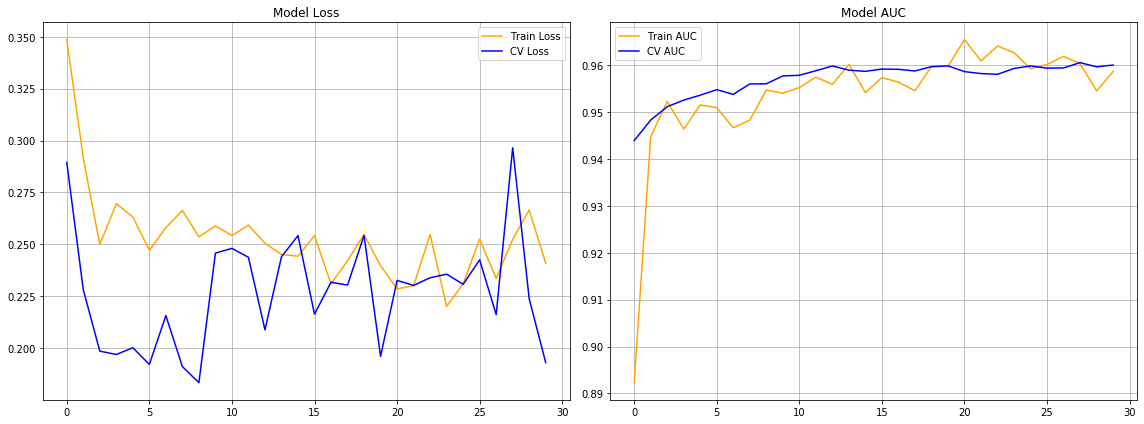

9/9 [==============================] - 0s 32ms/step - loss: 0.2473 - custom_auc: 0.9751


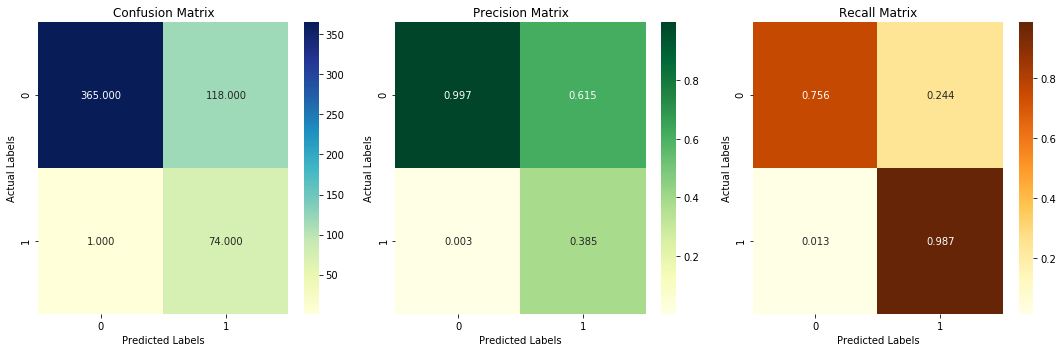

In [47]:
#plotting model performance
plot_model_performance(model_history)

simple_lstm = lstm_model(x_tr_tfidf_m.shape[1])
simple_lstm.load_weights('./model_checkpoint/simple_lstm_m2.h5')

tr_loss, tr_auc = simple_lstm.evaluate(x_tr_tfidf_m, y_tr, batch_size=batch)
cv_loss, cv_auc = simple_lstm.evaluate(x_cv_tfidf_m, y_cv, batch_size=batch)
te_loss, te_auc = simple_lstm.evaluate(x_te_tfidf_m, y_te, batch_size=batch)

#model prediction on Test data
model_prediction(simple_lstm, x_te_tfidf_m, y_te)

model_performances['Simple LSTM (tfidf w2v)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

## [3.4] LSTM Model with Word Embedding

In [48]:
def embed_lstm_model(shape, print_summary=False):
    model_input    = Input(shape=(shape, ), name='model_input')
    text_embeding  = Embedding(vocab_size, 300, #weights=[x_tr_embeding_matrix], \
                               input_length=shape, trainable=True, name='text_embeding')(model_input)
    lstm_layer1    = LSTM(64, name='lstm_layer1')(text_embeding)
    dense_layer1   = Dense(64, activation='relu', name='dense_layer1')(lstm_layer1)
    dropout_layer1 = Dropout(0.2, name='dropout_layer1')(dense_layer1)
    dense_layer2   = Dense(1, name='final_prediction')(dropout_layer1)
    lstm_model     = Model(inputs=model_input,outputs=dense_layer2)
    lstm_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-3) ,metrics=[custom_auc])
    if print_summary:
        lstm_model.summary()
    return lstm_model
stop_early = EarlyStopping(monitor='val_custom_auc', min_delta=0, patience=30, verbose=0, mode='max', \
                           restore_best_weights=True)

### [3.1.1] with Text Embeding as features

In [49]:
checkpoint = ModelCheckpoint("./model_checkpoint/lstm_model_wrd_embed_m1.h5",monitor="val_custom_auc",\
                             mode="max",save_best_only = True,verbose=1)

#training model with given data
lstm_model = embed_lstm_model(max_length, False)
history    = lstm_model.fit(x_tr_padded, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_padded, y_cv), \
                            use_multiprocessing=True, callbacks=[checkpoint, stop_early])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.3789 - custom_auc: 0.7220
Epoch 00001: val_custom_auc improved from -inf to 0.99026, saving model to ./model_checkpoint\lstm_model_wrd_embed_m1.h5
63/63 [==============================] - 6s 101ms/step - loss: 0.3789 - custom_auc: 0.7220 - val_loss: 0.1753 - val_custom_auc: 0.9903
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.2208 - custom_auc: 0.9778 ETA: 0s - loss: 0.2213 - custom_auc
Epoch 00002: val_custom_auc did not improve from 0.99026
63/63 [==============================] - 5s 86ms/step - loss: 0.2208 - custom_auc: 0.9778 - val_loss: 0.3618 - val_custom_auc: 0.9640
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.1408 - custom_auc: 0.9745
Epoch 00003: val_custom_auc did not improve from 0.99026
63/63 [==============================] - 5s 82ms/step - loss: 0.1408 - custom_auc: 0.9745 - val_loss: 0.2675 - val_custom_auc: 0.9835
Epoch 4/30
63/63 [====================

Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.0385 - custom_auc: 0.9947
Epoch 00029: val_custom_auc did not improve from 0.99676
63/63 [==============================] - 5s 82ms/step - loss: 0.0385 - custom_auc: 0.9947 - val_loss: 0.1592 - val_custom_auc: 0.9941
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.0385 - custom_auc: 0.9863
Epoch 00030: val_custom_auc did not improve from 0.99676
63/63 [==============================] - 5s 82ms/step - loss: 0.0385 - custom_auc: 0.9863 - val_loss: 0.1595 - val_custom_auc: 0.9941


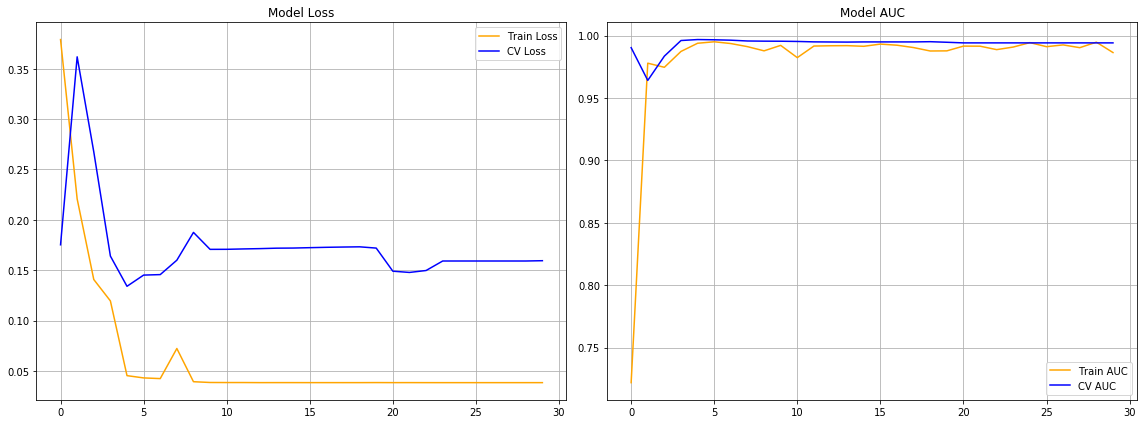

9/9 [==============================] - 0s 14ms/step - loss: 0.1208 - custom_auc: 0.9915


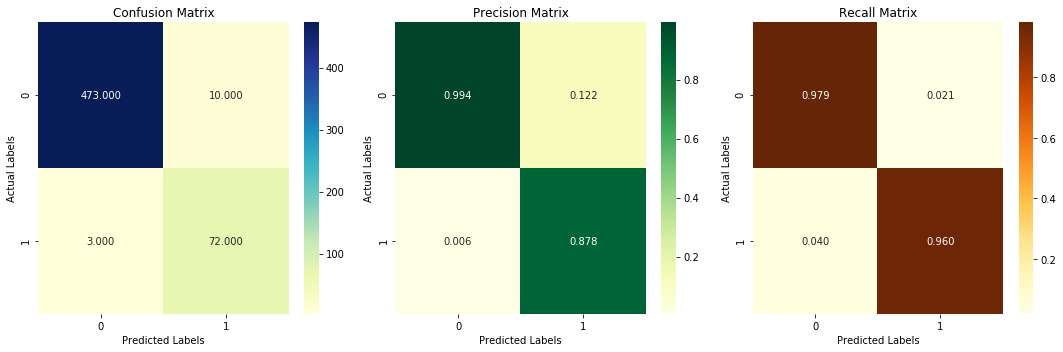

In [50]:
plot_model_performance(history)

lstm_model = embed_lstm_model(max_length, False)
lstm_model.load_weights('./model_checkpoint/lstm_model_wrd_embed_m1.h5')

tr_loss, tr_auc = lstm_model.evaluate(x_tr_padded, y_tr, batch_size=batch)
cv_loss, cv_auc = lstm_model.evaluate(x_cv_padded, y_cv, batch_size=batch)
te_loss, te_auc = lstm_model.evaluate(x_te_padded, y_te, batch_size=batch)

#model prediction on Test data
model_prediction(lstm_model, x_te_padded, y_te)

model_performances['LSTM Model (Embeded text feat)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

### [3.1.2] with Text Embeding + Numerical Features

In [51]:
tr_text_num_feat = np.hstack((x_tr_padded, x_tr[['text_length', 'presence_of_digit']]))
cv_text_num_feat = np.hstack((x_cv_padded, x_cv[['text_length', 'presence_of_digit']]))
te_text_num_feat = np.hstack((x_te_padded, x_te[['text_length', 'presence_of_digit']]))

In [54]:
checkpoint = ModelCheckpoint("./model_checkpoint/lstm_model_wrd_embed_m2.h5",monitor="val_custom_auc",mode="max",save_best_only = True,verbose=1)

lstm_model = embed_lstm_model(tr_text_num_feat.shape[1], False)
history    = lstm_model.fit(tr_text_num_feat, y_tr, batch_size=batch, epochs=epoch, validation_data=(cv_text_num_feat, y_cv), \
                            use_multiprocessing=True, callbacks=[checkpoint, stop_early])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.3189 - custom_auc: 0.8384
Epoch 00001: val_custom_auc improved from -inf to 0.99608, saving model to ./model_checkpoint\lstm_model_wrd_embed_m2.h5
63/63 [==============================] - 9s 140ms/step - loss: 0.3189 - custom_auc: 0.8384 - val_loss: 0.1015 - val_custom_auc: 0.9961
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1119 - custom_auc: 0.9948
Epoch 00002: val_custom_auc did not improve from 0.99608
63/63 [==============================] - 6s 96ms/step - loss: 0.1119 - custom_auc: 0.9948 - val_loss: 0.5306 - val_custom_auc: 0.9658
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.2211 - custom_auc: 0.9737
Epoch 00003: val_custom_auc did not improve from 0.99608
63/63 [==============================] - 7s 109ms/step - loss: 0.2211 - custom_auc: 0.9737 - val_loss: 0.2141 - val_custom_auc: 0.9742
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.125

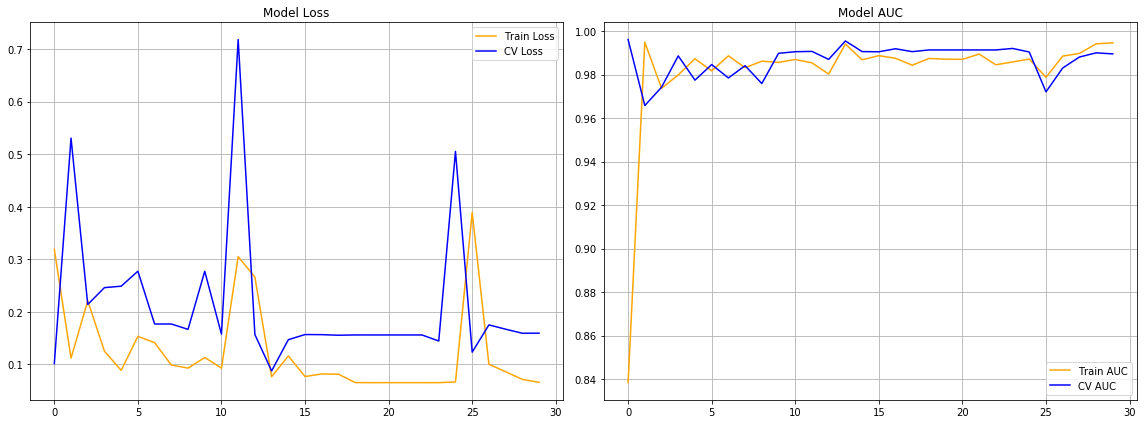

9/9 [==============================] - 0s 26ms/step - loss: 0.0715 - custom_auc: 0.9954


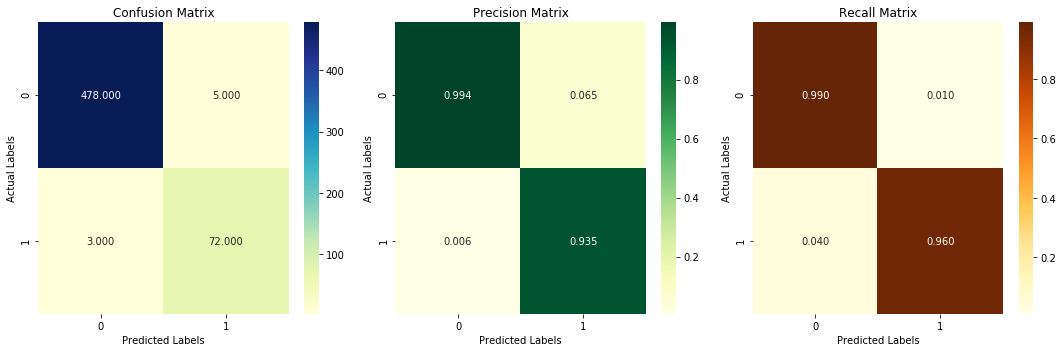

In [55]:
plot_model_performance(history)

lstm_model = embed_lstm_model(tr_text_num_feat.shape[1], False)
lstm_model.load_weights('./model_checkpoint/lstm_model_wrd_embed_m2.h5')

tr_loss, tr_auc = lstm_model.evaluate(tr_text_num_feat, y_tr, batch_size=batch)
cv_loss, cv_auc = lstm_model.evaluate(cv_text_num_feat, y_cv, batch_size=batch)
te_loss, te_auc = lstm_model.evaluate(te_text_num_feat, y_te, batch_size=batch)

#model prediction on test data
model_prediction(lstm_model, x_te_padded, y_te)

model_performances['LSTM Model(text+numerical feat)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

## [3.2] Two Layered LSTM

In [56]:
def two_layered_lstm_model(shape, print_summary=False):
    model_input    = Input(shape=(shape, ), name='model_input')
    text_embeding  = Embedding(vocab_size, 300, #weights=[x_tr_embeding_matrix], \
                               input_length=shape, trainable=True, name='text_embeding')(model_input)
    lstm_layer1    = LSTM(64, return_sequences=True, name='lstm_layer1')(text_embeding)
    lstm_layer2    = LSTM(64, name='lstm_layer2')(lstm_layer1)
    dense_layer1   = Dense(64, activation='relu', name='dense_layer1')(lstm_layer2)
    dropout_layer1 = Dropout(0.2, name='dropout_layer1')(dense_layer1)
    dense_layer2   = Dense(64, activation='relu', name='dense_layer2')(dropout_layer1)
    dropout_layer2 = Dropout(0.2, name='dropout_layer2')(dense_layer2)
    dense_layer3   = Dense(1, name='final_prediction')(dropout_layer2)
    lstm_model     = Model(inputs=model_input,outputs=dense_layer3)
    lstm_model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=1e-3) ,metrics=[custom_auc])
    if print_summary:
        lstm_model.summary()
    return lstm_model

stop_early = EarlyStopping(monitor='val_custom_auc', min_delta=0, patience=3, verbose=0, mode='max', \
                           restore_best_weights=True)

### [3.2.1] with Text Embeding as features

In [57]:
checkpoint = ModelCheckpoint("./model_checkpoint/two_layred_lstm_embed_text.h5",monitor="val_custom_auc",mode="max",save_best_only = True,verbose=1)

#training model with given data
lstm_model = two_layered_lstm_model(max_length, False)
history    = lstm_model.fit(x_tr_padded, y_tr, batch_size=batch, epochs=epoch, validation_data=(x_cv_padded, y_cv), \
                            use_multiprocessing=True, callbacks=[checkpoint, stop_early])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.3471 - custom_auc: 0.8060
Epoch 00001: val_custom_auc improved from -inf to 0.99739, saving model to ./model_checkpoint\two_layred_lstm_embed_text.h5
63/63 [==============================] - 8s 126ms/step - loss: 0.3471 - custom_auc: 0.8060 - val_loss: 0.0938 - val_custom_auc: 0.9974
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1425 - custom_auc: 0.9843
Epoch 00002: val_custom_auc did not improve from 0.99739
63/63 [==============================] - 7s 107ms/step - loss: 0.1425 - custom_auc: 0.9843 - val_loss: 0.1375 - val_custom_auc: 0.9956
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.0601 - custom_auc: 0.9940
Epoch 00003: val_custom_auc improved from 0.99739 to 0.99754, saving model to ./model_checkpoint\two_layred_lstm_embed_text.h5
63/63 [==============================] - 8s 120ms/step - loss: 0.0601 - custom_auc: 0.9940 - val_loss: 0.1523 - val_custom_auc: 0.9975

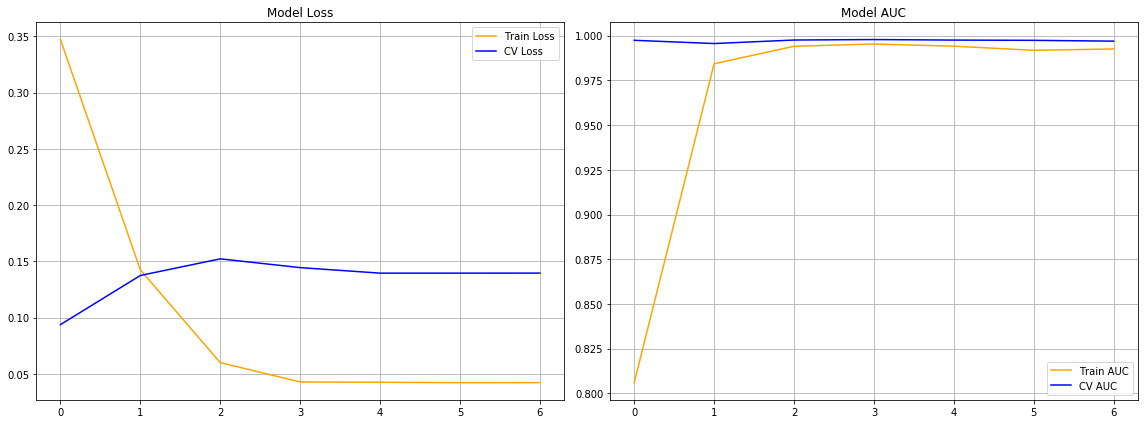

9/9 [==============================] - 0s 25ms/step - loss: 0.1188 - custom_auc: 0.9907


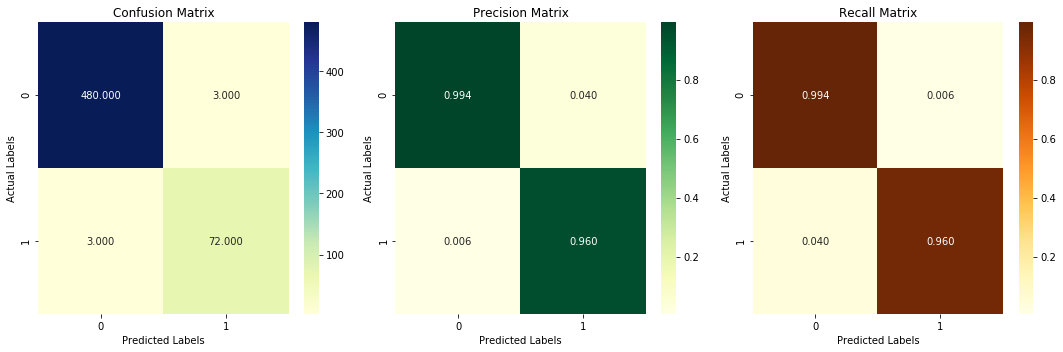

In [59]:
plot_model_performance(history)

lstm_model = two_layered_lstm_model(max_length, False)
lstm_model.load_weights('./model_checkpoint/two_layred_lstm_embed_text.h5')

tr_loss, tr_auc = lstm_model.evaluate(x_tr_padded, y_tr, batch_size=64)
cv_loss, cv_auc = lstm_model.evaluate(x_cv_padded, y_cv, batch_size=64)
te_loss, te_auc = lstm_model.evaluate(x_te_padded, y_te, batch_size=64)

#prediction on test data
model_prediction(lstm_model, x_te_padded, y_te)

model_performances['2-Layered LSTM Model(text feat)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

### [3.2.2] with Text Embeding + Numerical Features

In [60]:
tr_text_num_feat = np.hstack((x_tr_padded, x_tr[['text_length', 'presence_of_digit']]))
cv_text_num_feat = np.hstack((x_cv_padded, x_cv[['text_length', 'presence_of_digit']]))
te_text_num_feat = np.hstack((x_te_padded, x_te[['text_length', 'presence_of_digit']]))

In [61]:
checkpoint = ModelCheckpoint("./model_checkpoint/two_layred_lstm_embed_text_num.h5",monitor="val_custom_auc",mode="max", \
                             save_best_only = True,verbose=1)

lstm_model = two_layered_lstm_model(tr_text_num_feat.shape[1], False)
history    = lstm_model.fit(tr_text_num_feat, y_tr, batch_size=128, epochs=epoch, validation_data=(cv_text_num_feat, y_cv), \
                            use_multiprocessing=True, callbacks=[checkpoint, stop_early])

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 0.4722 - custom_auc: 0.4987
Epoch 00001: val_custom_auc improved from -inf to 0.98174, saving model to ./model_checkpoint\two_layred_lstm_embed_text_num.h5
32/32 [==============================] - 7s 205ms/step - loss: 0.4722 - custom_auc: 0.4987 - val_loss: 0.3520 - val_custom_auc: 0.9817
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.2268 - custom_auc: 0.9475
Epoch 00002: val_custom_auc improved from 0.98174 to 0.99536, saving model to ./model_checkpoint\two_layred_lstm_embed_text_num.h5
32/32 [==============================] - 7s 211ms/step - loss: 0.2268 - custom_auc: 0.9475 - val_loss: 0.0602 - val_custom_auc: 0.9954
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.0449 - custom_auc: 0.9948
Epoch 00003: val_custom_auc improved from 0.99536 to 0.99566, saving model to ./model_checkpoint\two_layred_lstm_embed_text_num.h5
32/32 [==============================] - 6s 202ms/st

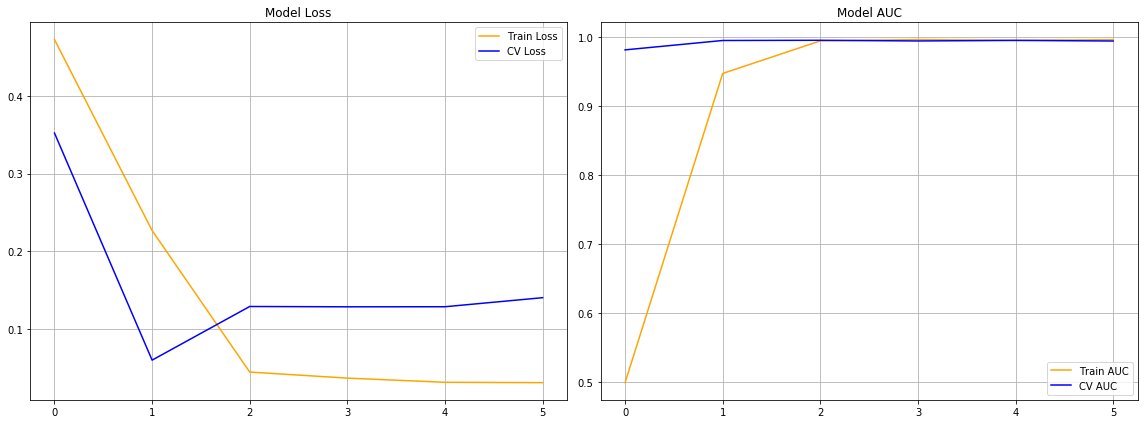

9/9 [==============================] - 0s 23ms/step - loss: 0.1222 - custom_auc: 0.9937


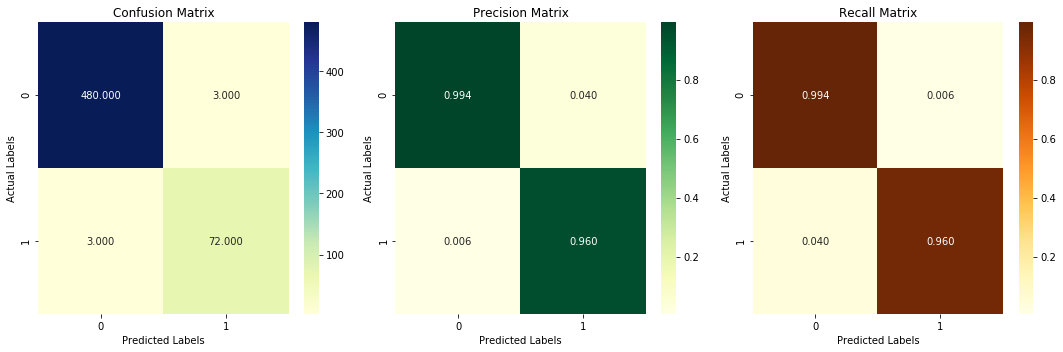

In [66]:
plot_model_performance(history)

lstm_model = two_layered_lstm_model(tr_text_num_feat.shape[1], False)
lstm_model.load_weights('./model_checkpoint/two_layred_lstm_embed_text_num.h5')

tr_loss, tr_auc = lstm_model.evaluate(tr_text_num_feat, y_tr, batch_size=64)
cv_loss, cv_auc = lstm_model.evaluate(cv_text_num_feat, y_cv, batch_size=64)
te_loss, te_auc = lstm_model.evaluate(te_text_num_feat, y_te, batch_size=64)

model_prediction(lstm_model, te_text_num_feat, y_te)

model_performances['2-Layered LSTM Model(text+numerical feat)'] = [tr_loss, tr_auc, cv_loss, cv_auc, te_loss, te_auc]

# [4] Conclusion

In [67]:
from prettytable import PrettyTable

sms_spam_dl = PrettyTable(['Model', 'Train Loss', 'Train AUC', 'CV Loss', 'CV AUC', 'Test Loss', 'Test AUC'])
for k, v in list(model_performances.items()):
    sms_spam_dl.add_row([k.center(30, ' '), round(v[0], 5), round(v[1], 5), round(v[2], 5), round(v[3], 5), \
                         round(v[4], 5), round(v[5], 5)])
    
print(sms_spam_dl)

+-------------------------------------------+------------+-----------+---------+---------+-----------+----------+
|                   Model                   | Train Loss | Train AUC | CV Loss |  CV AUC | Test Loss | Test AUC |
+-------------------------------------------+------------+-----------+---------+---------+-----------+----------+
|           Simple Dense (avg w2v)          |  0.24792   |  0.96316  | 0.19001 | 0.95897 |   0.1696  | 0.97431  |
|          Simple Dense (tfidf w2v)         |  0.25635   |  0.96455  | 0.27784 | 0.96068 |  0.18727  | 0.97461  |
|        Simple Dense Tuned(avg. w2v)       |  0.35553   |   0.9626  | 0.33786 | 0.95842 |  0.26733  | 0.97135  |
|       Simple Dense Tuned(tfidf w2v)       |   0.4454   |  0.96184  | 0.46406 | 0.96009 |  0.53524  | 0.97252  |
|           Simple LSTM (avg w2v)           |  0.22179   |   0.9658  | 0.19606 | 0.96127 |  0.18285  | 0.97332  |
|          Simple LSTM (tfidf w2v)          |  0.30983   |  0.96435  | 0.29653 | 0.96054

<p>
    We implemented three Deep Learned Techniques for classifiation of SMS text as Ham or Spam.
    <li>Simple Deep Neural Network</li>
    <li>Simple LSTM Model</li>
    <li>LSTM with Word Embedding</li>
</p>
<p>For given data, above category of models perform very well with AUC of more than 0.97. Here, text was encoded with Word Vectors either taking avg. of word vector for each word in sentence or using the TF-IDF measure.</p>
<p>Model which perform best on the given data is LSTM model with Word Embedding on given train data. The AUC performance of  this model is 0.99542 which was obtained on features made with, Embeded Text vector and Numerical feature of the original dataset.</p>

<hr>